In [0]:
pip install pandas hdbscan plotly python-dotenv umap-learn -q

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
pip install -U scikit-learn -q

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
dbutils.library.restartPython()

In [0]:

#general
import numpy as np
import pandas as pd
from ast import literal_eval

#graficar
import matplotlib.pyplot as plt
import plotly.express as px

#Modelos
from sklearn.cluster import DBSCAN, KMeans
import hdbscan
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn import cluster
from sklearn.model_selection import RandomizedSearchCV


#metricas
from sklearn.manifold import trustworthiness
from sklearn.metrics import make_scorer


In [0]:
%run /Workspace/Users/arestrepo15@summa-sci.com/proyecto_integrador/connection_datalake

## cargar dataset con embeddings

In [0]:
path = "df_split_250_embeddings_videos_youtube.csv"
file_path = f"abfss://presentation@sadatalakeproyecto.dfs.core.windows.net/{path}"
df_youtube_data = spark.read.option("header", True) \
                           .option("inferSchema", True) \
                           .option("sep", ";") \
                           .csv(file_path)

[FileInfo(path='abfss://presentation@sadatalakeproyecto.dfs.core.windows.net/dataset_videos_youtube_embeddings.csv', name='dataset_videos_youtube_embeddings.csv', size=689874729, modificationTime=1715291158000),
 FileInfo(path='abfss://presentation@sadatalakeproyecto.dfs.core.windows.net/dataset_videos_youtube_embeddings_300_tokens.csv', name='dataset_videos_youtube_embeddings_300_tokens.csv', size=1924220793, modificationTime=1717730763000),
 FileInfo(path='abfss://presentation@sadatalakeproyecto.dfs.core.windows.net/dataset_videos_youtube_embeddings_500_tokens.csv', name='dataset_videos_youtube_embeddings_500_tokens.csv', size=1292213144, modificationTime=1717730158000),
 FileInfo(path='abfss://presentation@sadatalakeproyecto.dfs.core.windows.net/df_curated_videos_youtube.csv', name='df_curated_videos_youtube.csv', size=91124952, modificationTime=1717729824000),
 FileInfo(path='abfss://presentation@sadatalakeproyecto.dfs.core.windows.net/df_split_250_embeddings_videos_youtube.csv', n

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType
import numpy as np
import ast

# Definir la UDF para convertir la cadena de texto a un array de floats
def convert_to_array(embedding_str):
    return np.array(ast.literal_eval(embedding_str), dtype=float).tolist()

convert_to_array_udf = udf(convert_to_array, ArrayType(DoubleType()))

# Aplicar la UDF a la columna 'embedding'
df_youtube_data = df_youtube_data.withColumn("embedding", convert_to_array_udf(df_youtube_data["embedding"]))

In [0]:
df_youtube_data_2023 = df_youtube_data.filter(df_youtube_data['year'] == 2023)

In [0]:
df_youtube_data_2024 = df_youtube_data.filter(df_youtube_data['year'] == 2024)

## Adecuar embeddings para ser usados como predictores de los modelos

In [0]:
embeddings = np.array(df_youtube_data_2024.select("embedding").rdd.map(lambda row: row[0]).collect())

In [0]:
embeddings.shape

(19431, 1536)

In [0]:
tsne_model= TSNE(n_components=2, random_state=42, perplexity=100, metric='cosine')
tsne_embeddings= tsne_model.fit_transform(embeddings)

In [0]:
fig = px.scatter(
    x=tsne_embeddings[:,0],
    y=tsne_embeddings[:,1],
    title="tsne embeddings",
    width=900,
    height=900,
    color_discrete_sequence=px.colors.qualitative.G10_r
    )
fig.show()

In [0]:
tsne_embeddings.shape

(19431, 2)

## CLUSTERING

## K-Means

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Optimal number of clusters: 2


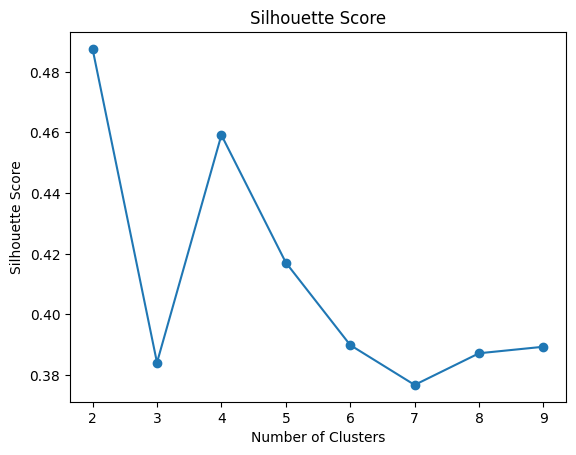

In [0]:
silhouette_scores = []
cluster_range = range(2, 10)  # Silhouette Score is not defined for 1 cluster

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
    kmeans.fit(tsne_embeddings)
    labels = kmeans.labels_
    score = silhouette_score(tsne_embeddings, labels,metric='euclidean')
    silhouette_scores.append(score)

best_n_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print("Optimal number of clusters:", best_n_clusters)

plt.plot(cluster_range, silhouette_scores, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")
plt.show()

Optimal number of clusters: 4


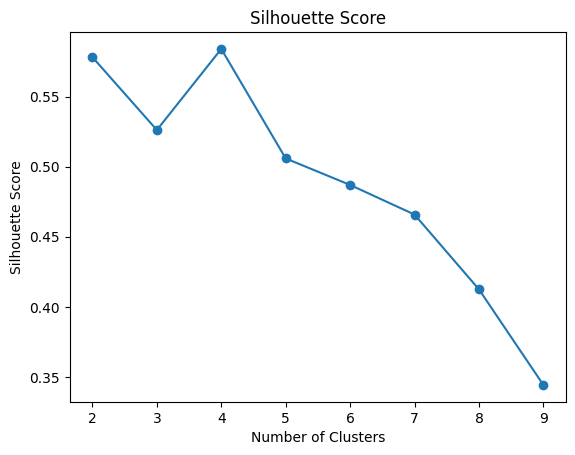

In [0]:
silhouette_scores = []
cluster_range = range(2, 10)  # Silhouette Score is not defined for 1 cluster

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
    kmeans.fit(tsne_embeddings)
    labels = kmeans.labels_
    score = silhouette_score(tsne_embeddings, labels,metric='cosine')
    silhouette_scores.append(score)

best_n_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print("Optimal number of clusters:", best_n_clusters)

plt.plot(cluster_range, silhouette_scores, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")
plt.show()

In [0]:
n_clusters=best_n_clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(tsne_embeddings)
kmeans_labels=kmeans.labels_

In [0]:
fig = px.scatter(
    x=tsne_embeddings[:,0],
    y=tsne_embeddings[:,1],
    color=kmeans_labels,
    title="Clustering",
    width=900,
    height=900,
    color_discrete_sequence=px.colors.qualitative.G10_r
    )
fig.show()

In [0]:
# Convertir el DataFrame de Spark a un DataFrame de pandas
df_youtube_data_2024_pd = df_youtube_data_2024.toPandas()

# Agregar la columna de etiquetas al DataFrame de pandas
df_youtube_data_2024_pd['kmeans_labels'] = kmeans_labels

In [0]:
for c in set(kmeans_labels):
    print(f"**********************************cluster: {c}************************************************")
    print(df_youtube_data_2024_pd[kmeans_labels==c]['text'].head().values)

**********************************cluster: 0************************************************
['volatilidad el yen la libra bueno la libra ni te cuento es verdad siempre han sido así lo que él dice es que bitcoin está subiendo porque la con la inflación cada vez se imprimen más billetes y eso hace que se rebaje el precio del dinero lo acabamos de ver en el eurod dólar bueno no le falta razón pero tampoco es eso aquí hay mucho más interés pero también dice que lo bueno que tiene bitcoin verdad es que lo podemos comparar contra el dólar o contra el euro qué es lo que estamos haciendo contra el dólar y sabemos si se está aumentando su valor o depreciando y sin embargo al dólar solo lo podemos ver contra el dólar a menos que hagamos un par de divisas pero el dólar su valoración subyacente es el índice del dólar la del euro es la del índice del euro y eso no va más no lo podemos comparar con otra cosa bueno habla una cantidad de bendiciones para bitcoin de cosas buenas para bitcoin e por si 

In [0]:
df_youtube_data_2024_pd[kmeans_labels==3]['text'].iloc[-1]

'green qué bien no yo me imagino que ustedes están felices mis amigos auto gt aquí está mi amigo aut gt dice anoche salí a la casa 3.5b en dot uy se me va a acabar la batería mis amigos se me olvidaba esta parte miren los voy a dejar porque se me va a acabar la batería del teléfono cuiden su dinero 45300 mañana 9 de la mañana hora montreal nos vemos pórtense bien hagan el bien no vamos no miren a kenny vamos vamos vamos bitcoin vamos vamos a ganar no me importa el sub y baja ojo solo debo acumular nos vemos mañana bye bye mis amigos'

In [0]:
df_youtube_data_2024_pd[kmeans_labels==3]['text'].iloc[1]

'por sus cabezas porque yo sé que hoy mucha gente está asustada yo tengo claro lo que yo estoy haciendo yo yo usted se acaba de dar cuenta que yo acabo de comprar otro poquito más y ojalá esto me dé tiempo para mañana ojalá dios me llegue el otro cheque para meterlo a ver los leo mis amigos ayúdenme con los likes por qué solo 500 likes porque a usted solo esto le gusta le gusta solo verlo hacia arriba no esto no solo funciona así también nos tienen que meter matracas de vez en cuando miguel saedro dice hola profe ya tiene mi like eh en qué onda va lo lo martin eh a ver lo veo espérate me paso al gráfico semanal para verle esto a usted es que este es un activo diferente una dos 3 cu una dos 3 cu c vea va haciendo onda 3 loer martin ve mi amigo va adelantado desde que lo dije no porque yo hablé de este activo cuando estaba por aquí pero ustedes son muy buenos entrando tarde verdad listo miguel saavedra ustedes son campeones uy ahí va bitcoin ya el'

In [0]:
# Definir el modelo DBSCAN
dbscan = DBSCAN(n_jobs=-1,eps =0.8)
dbscan_labels = dbscan.fit_predict(tsne_embeddings)
print(silhouette_score(tsne_embeddings, dbscan_labels, metric = "cosine"))

-0.8635604


In [0]:
fig = px.scatter(
    x=tsne_embeddings[:,0],
    y=tsne_embeddings[:,1],
    color=dbscan_labels,
    title="Clustering DBSCAN",
    width=900,
    height=900,
    color_discrete_sequence=px.colors.qualitative.G10_r
    )
fig.show()

In [0]:
from umap import UMAP
# Ajuste del modelo UMAP
umap_model = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1, metric='cosine')
umap_embeddings = umap_model.fit_transform(embeddings)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-fb34277d-f722-45ff-9cef-578f13c9b40e/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/local_disk0/.ephemeral_nfs/envs/pythonEnv-fb34277d-f722-45ff-9cef-578f13c9b40e/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning:

The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.



In [0]:
# Definir el modelo DBSCAN
dbscan = DBSCAN(n_jobs=-1,eps =0.4)
dbscan_labels = dbscan.fit_predict(umap_embeddings)
print(silhouette_score(umap_embeddings, dbscan_labels, metric = "cosine"))

-0.41647115


In [0]:
# Graficar los resultados utilizando Plotly
fig = px.scatter(
    x=umap_embeddings[:,0],
    y=umap_embeddings[:,1],
    color=dbscan_labels,
    title="UMAP embeddings",
    width=900,
    height=900,
    color_discrete_sequence=px.colors.qualitative.G10_r
)
fig.show()

In [0]:
# evalute the clusters
labels = dbscan.labels_
clustered = (labels >= 0)
    
coverage = np.sum(clustered) / embeddings.shape[0]
total_clusters = np.max(labels) + 1
cluster_sizes = np.bincount(labels[clustered]).tolist()

print(f"Percent of data retained: {coverage}")
print(f"Total Clusters found: {total_clusters}")
print(f"Cluster splits: {cluster_sizes}")

Percent of data retained: 1.0
Total Clusters found: 3
Cluster splits: [19286, 135, 10]


In [0]:
# Agregar la columna de etiquetas al DataFrame de pandas
df_youtube_data_2024_pd['dbscan_labels_UMAP'] = dbscan_labels

In [0]:
for c in set(dbscan_labels):
    print(f"**********************************cluster: {c}************************************************")
    print(df_youtube_data_2024_pd[df_youtube_data_2024_pd['dbscan_labels_UMAP']==c]['text'].head().values)

**********************************cluster: 0************************************************
['por qué comprar ahora google y esperar un poco para comprar bitcoin. saludos cordiales bienvenido a bolsas hoy martes 2 de abril bueno tenemos muchos mercados que están corrigiendo estamos viendo a bitcoin en la serie de 4 horas pero pasaremos enseguida a los análisis porque además hoy desde el punto de vista fundamental vamos a conocer datos desde estados unidos datos relevantes que pueden mover a cualquiera de los dos lados a las bolsas vamos a ver cómo te voy a ir contando toda esta historia porque quiero que saqu es una conclusión o al menos que tengas en perspectiva que todo lo que lees todo lo que escucha y todo lo que ves no tiene siempre por qué tener la razón o ser bueno vamos por pasos porque es que vienes buscando aquí algún análisis eh buscando una oportunidad de negociar vamos a empezar por lo siguiente este señor pertenece a un grupo de inversión como puedes ver líder de un grup

In [0]:
# Definir los valores de eps y min_samples
eps_values = np.linspace(0.1, 1.0, 5)
min_samples_values = [5, 10, 50, 100, 200]

# Crear un DataFrame para almacenar los resultados
results_dbscan_df = pd.DataFrame(columns=['eps', 'min_samples', 'silhouette_score', 'percent_data_retained', 'total_clusters', 'cluster_sizes'])

# Iterar sobre los valores de eps y min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        # Entrenar el modelo DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        dbscan_labels = dbscan.fit_predict(tsne_embeddings)
        
        # Calcular métricas
        labels = dbscan.labels_
        clustered = (labels >= 0)
        if len(set(labels))>1:
            silhouette= silhouette_score(tsne_embeddings, labels , metric = "cosine")
        else:
            silhouette = None
        coverage = np.sum(clustered) / tsne_embeddings.shape[0]
        total_clusters = np.max(labels) + 1
        cluster_sizes = np.bincount(labels[clustered]).tolist()

        # Number of clusters in labels, ignoring noise if present.

        n_noise_ = list(labels).count(-1)

         # Crear un DataFrame temporal para el resultado actual
        temp_df = pd.DataFrame({
            'eps': [eps],
            'min_samples': [min_samples],
            'silhouette_score': [silhouette],
            'percent_data_retained': [coverage],
            'total_clusters': [total_clusters],
            'cluster_sizes': [cluster_sizes]
        })
        
        # Concatenar el DataFrame temporal al DataFrame principal
        results_dbscan_df = pd.concat([results_dbscan_df, temp_df], ignore_index=True)

In [0]:
# Mostrar el DataFrame con los resultados
results_dbscan_df

eps  ...                                      cluster_sizes
0   0.100  ...  [13, 7, 6, 13, 6, 6, 11, 7, 7, 5, 5, 7, 10, 5,...
1   0.100  ...                                           [10, 10]
2   0.100  ...                                                 []
3   0.100  ...                                                 []
4   0.100  ...                                                 []
5   0.325  ...  [50, 16, 26, 8, 100, 9, 6, 14, 7, 59, 10, 8, 6...
6   0.325  ...  [88, 10, 43, 19, 13, 27, 49, 18, 14, 19, 15, 2...
7   0.325  ...                                                 []
8   0.325  ...                                                 []
9   0.325  ...                                                 []
10  0.550  ...  [19, 25, 229, 218, 18, 484, 10, 81, 1372, 9, 1...
11  0.550  ...  [10, 68, 20, 34, 104, 21, 16, 297, 145, 39, 18...
12  0.550  ...                                               [58]
13  0.550  ...                                                 []
14  0.550  ...                                                 []
15  0.775  ...  [448, 72, 27, 170, 3261, 15, 160, 10, 5, 9, 10...
16  0.775  ...  [26, 247, 246, 19, 522, 89, 1477, 104, 32, 204...
17  0.775  ...                                           [97, 68]
18  0.775  ...                                                 []
19  0.775  ...                                                 []
20  1.000  ...  [4832, 36, 45, 11997, 41, 285, 62, 109, 8, 96,...
21  1.000  ...  [855, 609, 2815, 16, 101, 8, 42, 151, 141, 103...
22  1.000  ...                     [106, 67, 105, 89, 89, 82, 79]
23  1.000  ...                                                 []
24  1.000  ...                                                 []

[25 rows x 6 columns]

In [0]:
# Definir los valores de eps y min_samples
eps_values = np.linspace(0.1, 1.0, 5)
min_samples_values = [5, 10, 50, 100, 200]

# Crear un DataFrame para almacenar los resultados
results_dbscan_df_2 = pd.DataFrame(columns=['eps', 'min_samples', 'silhouette_score', 'percent_data_retained', 'total_clusters', 'cluster_sizes'])

# Iterar sobre los valores de eps y min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        # Entrenar el modelo DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        dbscan_labels = dbscan.fit_predict(tsne_embeddings)
        
        # Calcular métricas
        labels = dbscan.labels_
        clustered = (labels >= 0)
        if len(set(labels))>1:
            silhouette= silhouette_score(tsne_embeddings, labels , metric = "cosine")
        else:
            silhouette = None
        coverage = np.sum(clustered) / tsne_embeddings.shape[0]
        total_clusters = np.max(labels) + 1
        cluster_sizes = np.bincount(labels[clustered]).tolist()

         # Crear un DataFrame temporal para el resultado actual
        temp_df = pd.DataFrame({
            'eps': [eps],
            'min_samples': [min_samples],
            'silhouette_score': [silhouette],
            'percent_data_retained': [coverage],
            'total_clusters': [total_clusters],
            'cluster_sizes': [cluster_sizes]
        })
        
        # Concatenar el DataFrame temporal al DataFrame principal
        results_dbscan_df_2 = pd.concat([results_dbscan_df_2, temp_df], ignore_index=True)


In [0]:
# Mostrar el DataFrame con los resultados
results_dbscan_df_2

eps min_samples  ... total_clusters  cluster_sizes
0   0.100           5  ...              1        [19431]
1   0.100          10  ...              1        [19431]
2   0.100          50  ...              1        [19431]
3   0.100         100  ...              1        [19431]
4   0.100         200  ...              1        [19431]
5   0.325           5  ...              1        [19431]
6   0.325          10  ...              1        [19431]
7   0.325          50  ...              1        [19431]
8   0.325         100  ...              1        [19431]
9   0.325         200  ...              1        [19431]
10  0.550           5  ...              1        [19431]
11  0.550          10  ...              1        [19431]
12  0.550          50  ...              1        [19431]
13  0.550         100  ...              1        [19431]
14  0.550         200  ...              1        [19431]
15  0.775           5  ...              1        [19431]
16  0.775          10  ...              1        [19431]
17  0.775          50  ...              1        [19431]
18  0.775         100  ...              1        [19431]
19  0.775         200  ...              1        [19431]
20  1.000           5  ...              1        [19431]
21  1.000          10  ...              1        [19431]
22  1.000          50  ...              1        [19431]
23  1.000         100  ...              1        [19431]
24  1.000         200  ...              1        [19431]

[25 rows x 6 columns]

In [0]:
dbscan = DBSCAN(eps=1, min_samples=10, metric='euclidean')
dbscan_labels = dbscan.fit_predict(tsne_embeddings)

In [0]:
# Reducir la dimensionalidad de los embeddings a 2D con UMAP
umap_model = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embeddings_2d = umap_model.fit_transform(embeddings)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-d3c5e51e-01d1-4c86-8472-834058ff4e23/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



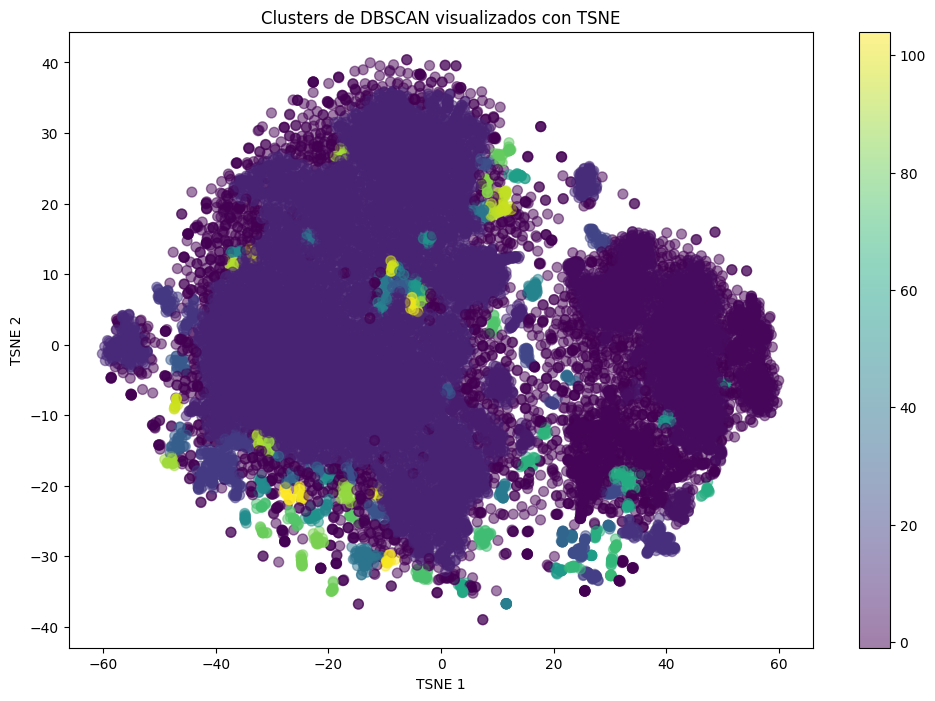

In [0]:
# Graficar los clusters de DBSCAN
plt.figure(figsize=(12, 8))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=dbscan_labels, cmap='viridis', s=50, alpha=0.5)
plt.colorbar()
plt.title('Clusters de DBSCAN visualizados con TSNE')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.show()

In [0]:
# Convertir el DataFrame de Spark a un DataFrame de pandas
df_youtube_data_2024_pd = df_youtube_data_2024.toPandas()

# Agregar la columna de etiquetas al DataFrame de pandas
df_youtube_data_2024_pd['dbscan_labels'] = dbscan_labels

In [0]:
for c in set(dbscan_labels):
    print(f"**********************************cluster: {c}************************************************")
    print(df_youtube_data_2024_pd[dbscan_labels==c]['text'].head().values)

**********************************cluster: 0************************************************
['por qué comprar ahora google y esperar un poco para comprar bitcoin. saludos cordiales bienvenido a bolsas hoy martes 2 de abril bueno tenemos muchos mercados que están corrigiendo estamos viendo a bitcoin en la serie de 4 horas pero pasaremos enseguida a los análisis porque además hoy desde el punto de vista fundamental vamos a conocer datos desde estados unidos datos relevantes que pueden mover a cualquiera de los dos lados a las bolsas vamos a ver cómo te voy a ir contando toda esta historia porque quiero que saqu es una conclusión o al menos que tengas en perspectiva que todo lo que lees todo lo que escucha y todo lo que ves no tiene siempre por qué tener la razón o ser bueno vamos por pasos porque es que vienes buscando aquí algún análisis eh buscando una oportunidad de negociar vamos a empezar por lo siguiente este señor pertenece a un grupo de inversión como puedes ver líder de un grup

In [0]:
# Definir los valores de eps y min_samples
eps_values = np.linspace(0.1, 1.0, 5)
min_samples_values = [5, 10, 50, 100, 200]

# Crear un DataFrame para almacenar los resultados
results_dbscan_df_3 = pd.DataFrame(columns=['eps', 'min_samples', 'silhouette_score', 'percent_data_retained', 'total_clusters', 'cluster_sizes'])

# Iterar sobre los valores de eps y min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        # Entrenar el modelo DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        dbscan_labels = dbscan.fit_predict(umap_embeddings)
        
        # Calcular métricas
        labels = dbscan.labels_
        clustered = (labels >= 0)
        if len(set(labels))>1:
            silhouette= silhouette_score(umap_embeddings, labels , metric = "cosine")
        else:
            silhouette = None
        coverage = np.sum(clustered) / umap_embeddings.shape[0]
        total_clusters = np.max(labels) + 1
        cluster_sizes = np.bincount(labels[clustered]).tolist()

         # Crear un DataFrame temporal para el resultado actual
        temp_df = pd.DataFrame({
            'eps': [eps],
            'min_samples': [min_samples],
            'silhouette_score': [silhouette],
            'percent_data_retained': [coverage],
            'total_clusters': [total_clusters],
            'cluster_sizes': [cluster_sizes]
        })
        
        # Concatenar el DataFrame temporal al DataFrame principal
        results_dbscan_df_3 = pd.concat([results_dbscan_df_3, temp_df], ignore_index=True)

In [0]:
results_dbscan_df_3

eps  ...                                      cluster_sizes
0   0.100  ...  [6, 4769, 52, 125, 12990, 11, 10, 104, 18, 200...
1   0.100  ...  [3474, 914, 85, 106, 42, 12179, 11, 131, 104, ...
2   0.100  ...  [152, 140, 175, 96, 173, 160, 302, 74, 101, 14...
3   0.100  ...                                                 []
4   0.100  ...                                                 []
5   0.325  ...                     [19256, 126, 10, 11, 9, 11, 7]
6   0.325  ...                     [5461, 13791, 126, 10, 11, 11]
7   0.325  ...                [5208, 13226, 314, 56, 189, 91, 52]
8   0.325  ...            [3853, 1108, 183, 12687, 309, 106, 102]
9   0.325  ...       [419, 1962, 296, 880, 3246, 1006, 4833, 372]
10  0.550  ...                                        [19421, 10]
11  0.550  ...                                        [19421, 10]
12  0.550  ...                                 [5472, 13783, 135]
13  0.550  ...                                 [5446, 13705, 135]
14  0.550  ...                                 [5153, 13232, 315]
15  0.775  ...                                        [19421, 10]
16  0.775  ...                                        [19421, 10]
17  0.775  ...                                            [19414]
18  0.775  ...                                 [5479, 13780, 135]
19  0.775  ...                                      [5453, 13767]
20  1.000  ...                                            [19431]
21  1.000  ...                                            [19431]
22  1.000  ...                                            [19430]
23  1.000  ...                                            [19423]
24  1.000  ...                                      [5522, 13800]

[25 rows x 6 columns]

In [0]:
eps = 0.325
min_samples = 100
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
dbscan_labels = dbscan.fit_predict(umap_embeddings)

In [0]:
# Graficar los resultados utilizando Plotly
fig = px.scatter(
    x=umap_embeddings[:,0],
    y=umap_embeddings[:,1],
    color=dbscan_labels,
    title="UMAP embeddings",
    width=900,
    height=900,
    color_discrete_sequence=px.colors.qualitative.G10_r
)
fig.show()

In [0]:
# Agregar la columna de etiquetas al DataFrame de pandas
df_youtube_data_2024_pd['dbscan_labels_umap'] = dbscan_labels

In [0]:
for c in set(dbscan_labels):
    print(f"**********************************cluster: {c}************************************************")
    print(df_youtube_data_2024_pd[df_youtube_data_2024_pd['dbscan_labels_umap']==c]['text'].head().values)

**********************************cluster: 0************************************************
['un artículo que además dentro de poco voy a empezar a publicar ahí y a recuperar siempre digo quiero recuperar mis artículos en investing con los que colaboro desde hace muchos años falta de tiempo pero ahora parece que lo voy a poder tener y también voy a publicar en ya les diré en dónde donde mismo lo hace este señor y otros artículos que yo les he ido trayendo en inglés en estados unidos vamos a ver cómo nos va verdad a ver si damos ese saltito bueno siguiente diapositiva aquí lo que nos viene a decir es lo siguiente sectores que siguen ofreciendo oportunidades pero se recomienda cautela debido a la posibilidad de que se produzca un re inicio del mercado un un reinicio traducido así del inglés es una corrección ir a buscar liquidez sabemos que los índices están ahora mismo al borde de esto precisamente no bueno dice que el entorno económico actual es favorable para las acciones y la reserv

In [0]:
print(df_youtube_data_2024_pd[df_youtube_data_2024_pd['dbscan_labels_umap']==6]['text'].values)

['impulsando también pero empieza a estar en esa situación que nos puede dar esa oportunidad de comprar barato a un precio razonable porque hay muchos que lo están viendo y vios además también cuál era el precio razonable objetivo entonces todo esto te lo voy a ir desarrollando mañana hay otra compañía pero también la voy a dejar para mañana para que esto no se alargue mucho y para que le des una vuelta a esta mañana veremos la otra y los datos fundamentales qué te parece la idea así vamos avanzando juntos con esta parte formativa que es al fin y al cabo la principal en este canal recibe un cardial saludo será más y mejor un saludo'
 'y mejor un saludo'
 'lunes ya con la pantalla interactiva y con toda la historia te deseo un gran fin de semana que descanses yo también y que todo va a ser más y mejor un saludo al'
 'lo que nosotros deimos tiene más o menos futuro es decir lo hará mejor o lo hará peor y lo vamos a hacer porque haremos un test a tiempo real mañana faltarán nueve y será m